In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.interpolate as interp
from astropy.modeling import models, fitting
import scipy.optimize as opt
import scipy.ndimage
from matplotlib.cm import ScalarMappable

In [2]:
with open('../Data/allFLYs.pkl', 'rb') as pickle_file:
    allFLYs = pickle.load(pickle_file, encoding = 'latin1')

In [3]:
#gathering theta and x y signal data

length = 0
indices = [1]
#for i in range(1,2):
for i in indices:
    length += len(allFLYs[i]['x'])

#preallocating arrays for x, y, dish signal at each frequency, and angle for each dish
dish1signal, dish2signal, dish3signal, dish4signal = np.zeros((256, length)),np.zeros((256, length)),np.zeros((256, length)),np.zeros((256, length))
x_loc, y_loc = np.zeros(length), np.zeros(length)
dish1_thetax, dish2_thetax, dish3_thetax, dish4_thetax = np.zeros(length),np.zeros(length),np.zeros(length),np.zeros(length)
dish1_thetay, dish2_thetay, dish3_thetay, dish4_thetay = np.zeros(length),np.zeros(length),np.zeros(length),np.zeros(length)

countermin = 0
countermax = 0
#for i in range(1,2):
for i in indices:
    countermax += len(allFLYs[i]['x'])
    
    x_loc[countermin:countermax] = allFLYs[i]['x']
    y_loc[countermin:countermax] = allFLYs[i]['y']
    
    dish1_thetax[countermin:countermax] = allFLYs[i]['thetaX'][0]
    dish2_thetax[countermin:countermax] = allFLYs[i]['thetaX'][1]
    dish3_thetax[countermin:countermax] = allFLYs[i]['thetaX'][2]
    dish4_thetax[countermin:countermax] = allFLYs[i]['thetaX'][3]
    
    dish1_thetay[countermin:countermax] = allFLYs[i]['thetaY'][0]
    dish2_thetay[countermin:countermax] = allFLYs[i]['thetaY'][1]
    dish3_thetay[countermin:countermax] = allFLYs[i]['thetaY'][2]
    dish4_thetay[countermin:countermax] = allFLYs[i]['thetaY'][3]
    
    autospectra = np.array(allFLYs[i]['autos'])
    
    for j in range(0, 256):
        dish1signal[j][countermin:countermax] = autospectra[0][:,j]
        dish2signal[j][countermin:countermax] = autospectra[1][:,j]
        dish3signal[j][countermin:countermax] = autospectra[2][:,j]
        dish4signal[j][countermin:countermax] = autospectra[3][:,j]
    
    countermin += len(allFLYs[i]['x'])

In [4]:
#creating theta-space interpolations

xi = np.linspace(-0.2, 0.2, 200)
yi = np.linspace(-0.2, 0.2, 200)
xspace, yspace = np.meshgrid(xi, yi)
interp_dish1 = interp.griddata((dish1_thetax, dish1_thetay), dish1signal[50], (xi[None,:], yi[:,None]), method = 'linear')
interp_dish2 = interp.griddata((dish2_thetax, dish2_thetay), dish2signal[50], (xi[None,:], yi[:,None]), method = 'linear')
interp_dish3 = interp.griddata((dish3_thetax, dish3_thetay), dish3signal[50], (xi[None,:], yi[:,None]), method = 'linear')
interp_dish4 = interp.griddata((dish4_thetax, dish4_thetay), dish4signal[50], (xi[None,:], yi[:,None]), method = 'linear')

In [12]:
#defining gaussian fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    g = offset + amplitude * np.exp(-(((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

In [6]:
#getting better initial guesses for xmeans and ymeans

xmean1 = dish1_thetax[np.where(dish1signal[50]==max(dish1signal[50]))]
xmean2 = dish2_thetax[np.where(dish2signal[50]==max(dish2signal[50]))]
xmean3 = dish3_thetax[np.where(dish3signal[50]==max(dish3signal[50]))]
xmean4 = dish4_thetax[np.where(dish4signal[50]==max(dish4signal[50]))]

ymean1 = dish1_thetay[np.where(dish1signal[50]==max(dish1signal[50]))]
ymean2 = dish2_thetay[np.where(dish2signal[50]==max(dish2signal[50]))]
ymean3 = dish3_thetay[np.where(dish3signal[50]==max(dish3signal[50]))]
ymean4 = dish4_thetay[np.where(dish4signal[50]==max(dish4signal[50]))]

In [14]:
#creating gaussian fits

datapoints1 = (dish1_thetax, dish1_thetay)
datapoints2 = (dish2_thetax, dish2_thetay)
datapoints3 = (dish3_thetax, dish3_thetay)
datapoints4 = (dish4_thetax, dish4_thetay)

initial_guess1 = (max(dish1signal[50]), xmean1, ymean1, 0.05, 0.05, 0)
initial_guess2 = (max(dish2signal[50]), xmean2, ymean2, 0.05, 0.05, 0)
initial_guess3 = (max(dish3signal[50]), xmean3, ymean3, 0.05, 0.05, 0)
initial_guess4 = (max(dish4signal[50]), xmean4, ymean4, 0.05, 0.05, 0)

opt1, cov1 = opt.curve_fit(twoD_Gaussian, datapoints1, dish1signal[50], p0 = initial_guess1, method = 'dogbox')
opt2, cov2 = opt.curve_fit(twoD_Gaussian, datapoints2, dish2signal[50], p0 = initial_guess2, method = 'dogbox')
opt3, cov3 = opt.curve_fit(twoD_Gaussian, datapoints3, dish3signal[50], p0 = initial_guess3, method = 'dogbox')
opt4, cov4 = opt.curve_fit(twoD_Gaussian, datapoints4, dish4signal[50], p0 = initial_guess4, method = 'dogbox')

err1 = np.sqrt(np.diag(cov1))
err2 = np.sqrt(np.diag(cov2))
err3 = np.sqrt(np.diag(cov3))
err4 = np.sqrt(np.diag(cov4))

#creating gaussian models in order to plot over a meshgrid

gauss1 = models.Gaussian2D(opt1[0], opt1[1], opt1[2], opt1[3], opt1[4], opt1[5])
gauss2 = models.Gaussian2D(opt2[0], opt2[1], opt2[2], opt2[3], opt2[4], opt2[5])
gauss3 = models.Gaussian2D(opt3[0], opt3[1], opt3[2], opt3[3], opt3[4], opt3[5])
gauss4 = models.Gaussian2D(opt4[0], opt4[1], opt4[2], opt4[3], opt4[4], opt4[5])

In [15]:
#finding the center of mass of the background-subtracted signal

sig_tot1 = 0
sig_tot2 = 0
sig_tot3 = 0
sig_tot4 = 0

count1 = 0
count2 = 0
count3 = 0
count4 = 0

for i in range(len(interp_dish1)):
    for j in range(len(interp_dish1[i])):
        if (np.sqrt((xspace[i][j]-opt1[1])**2 + (yspace[i][j]-opt1[2])**2) > 5*opt1[3]):
            sig_tot1 += interp_dish1[i][j]
            count1 += 1
        if (np.sqrt((xspace[i][j]-opt2[1])**2 + (yspace[i][j]-opt2[2])**2) > 5*opt2[4]):
            sig_tot2 += interp_dish2[i][j]
            count2 += 1
        if (np.sqrt((xspace[i][j]-opt3[1])**2 + (yspace[i][j]-opt3[2])**2) > 5*opt3[4]):
            sig_tot3 += interp_dish3[i][j]
            count3 += 1
        if (np.sqrt((xspace[i][j]-opt4[1])**2 + (yspace[i][j]-opt4[2])**2) > 5*opt4[4]):
            sig_tot4 += interp_dish4[i][j]
            count4 += 1

back1 = sig_tot1 / count1
back2 = sig_tot2 / count2
back3 = sig_tot3 / count3
back4 = sig_tot4 / count4

interp_backsub1 = np.zeros(interp_dish1.shape)
interp_backsub2 = np.zeros(interp_dish2.shape)
interp_backsub3 = np.zeros(interp_dish3.shape)
interp_backsub4 = np.zeros(interp_dish4.shape)

for i in range(len(interp_dish1)):
    for j in range(len(interp_dish1[i])):
        interp_backsub1[i][j] = interp_dish1[i][j] - back1
        interp_backsub2[i][j] = interp_dish2[i][j] - back1
        interp_backsub3[i][j] = interp_dish3[i][j] - back1
        interp_backsub4[i][j] = interp_dish4[i][j] - back1
        
xy1 = scipy.ndimage.center_of_mass(interp_backsub1)
xy2 = scipy.ndimage.center_of_mass(interp_backsub2)
xy3 = scipy.ndimage.center_of_mass(interp_backsub3)
xy4 = scipy.ndimage.center_of_mass(interp_backsub4)

xy_rad1 = ((xy1[1]-100)/100 * 0.2, (xy1[0]-100)/100 *0.2)
xy_rad2 = ((xy2[1]-100)/100 * 0.2, (xy2[0]-100)/100 *0.2)
xy_rad3 = ((xy3[1]-100)/100 * 0.2, (xy3[0]-100)/100 *0.2)
xy_rad4 = ((xy4[1]-100)/100 * 0.2, (xy4[0]-100)/100 *0.2)

Text(0, 0.5, 'radians')

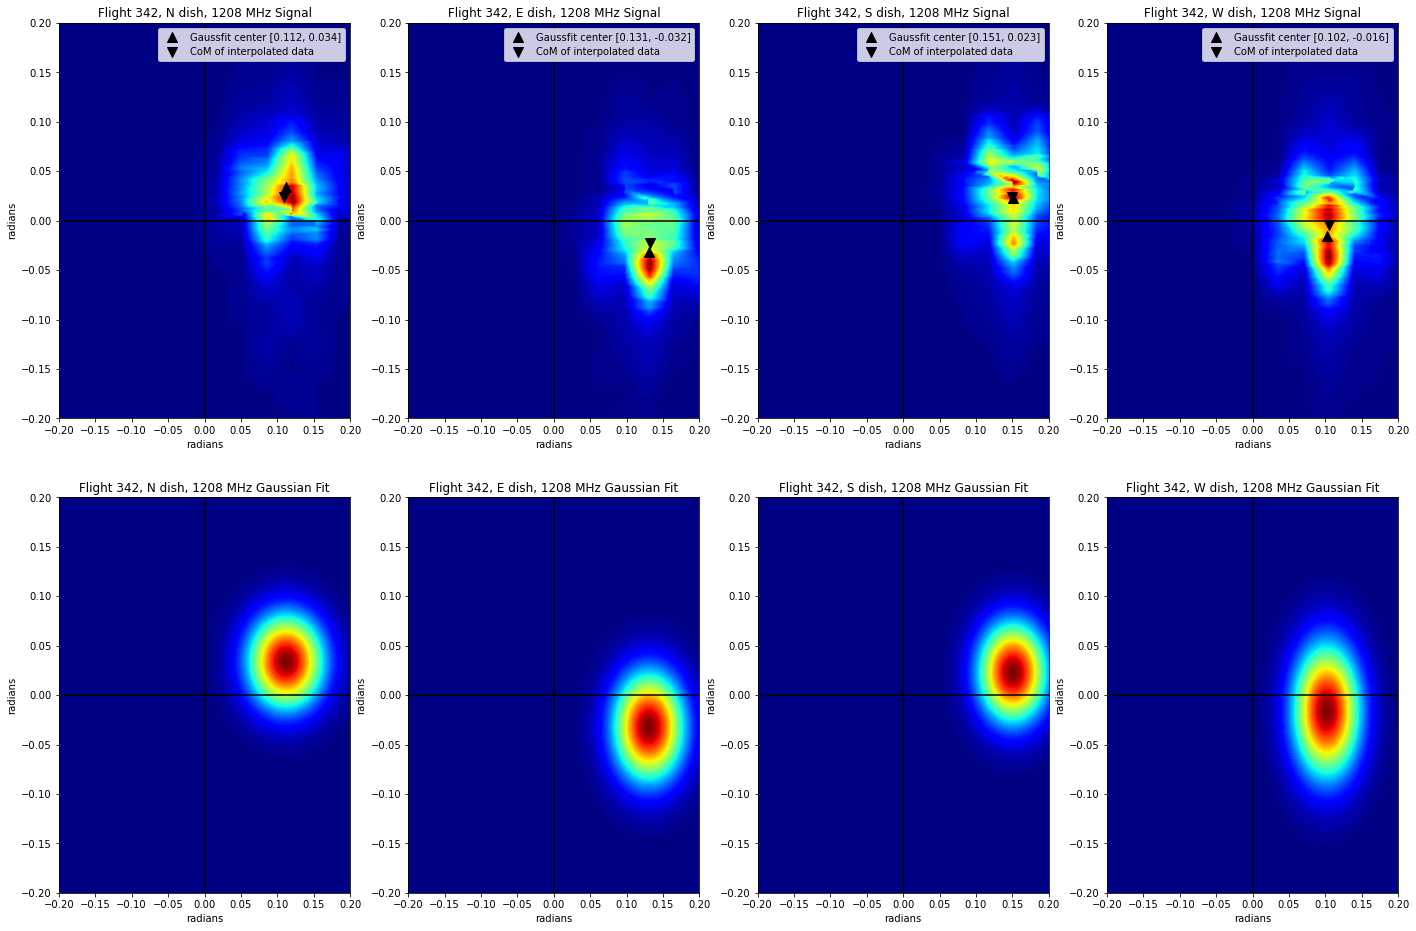

In [16]:
#plotting interpolated data, gaussian fits, CoM, and Gaussfit centers

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (24,16))
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

label1 = 'Gaussfit center ['+str(np.round(opt1[1],3))+ ', '+ str(np.round(opt1[2],3))+']'
label2 = 'Gaussfit center ['+str(np.round(opt2[1],3))+ ', '+ str(np.round(opt2[2],3))+']'
label3 = 'Gaussfit center ['+str(np.round(opt3[1],3))+ ', '+ str(np.round(opt3[2],3))+']'
label4 = 'Gaussfit center ['+str(np.round(opt4[1],3))+ ', '+ str(np.round(opt4[2],3))+']'

ax1.contourf(xi,yi,interp_dish1,100,cmap='jet')
ax1.set_title('Flight 342, N dish, 1208 MHz Signal')
ax1.scatter(opt1[1], opt1[2], color = 'black', marker = '^', s = 100, label = label1)
ax1.scatter(xy_rad1[0], xy_rad1[1], color = 'black', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax1.legend()
ax1.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax1.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax1.set_xlabel('radians')
ax1.set_ylabel('radians')

ax2.contourf(xi,yi,interp_dish2,100,cmap='jet', vmin = 0)
ax2.set_title('Flight 342, E dish, 1208 MHz Signal')
ax2.scatter(opt2[1], opt2[2], color = 'black', marker = '^', s = 100,label = label2)
ax2.scatter(xy_rad2[0], xy_rad2[1], color = 'black', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax2.legend()
ax2.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax2.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax2.set_xlabel('radians')
ax2.set_ylabel('radians')

ax3.contourf(xi,yi,interp_dish3,100,cmap='jet', vmin = 0)
ax3.set_title('Flight 342, S dish, 1208 MHz Signal')
ax3.scatter(opt3[1], opt3[2], color = 'black', marker = '^', s = 100,label = label3)
ax3.scatter(xy_rad3[0], xy_rad3[1], color = 'black', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax3.legend()
ax3.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax3.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax3.set_xlabel('radians')
ax3.set_ylabel('radians')

ax4.contourf(xi,yi,interp_dish4,100,cmap='jet', vmin = 0)
ax4.set_title('Flight 342, W dish, 1208 MHz Signal')
ax4.scatter(opt4[1], opt4[2], color = 'black', marker = '^', s=100, label = label4)
ax4.scatter(xy_rad4[0], xy_rad4[1], color = 'black', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax4.legend()
ax4.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax4.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax4.set_xlabel('radians')
ax4.set_ylabel('radians')

ax5.contourf(xi,yi,gauss1(xspace, yspace),100,cmap='jet', vmin = 0)
ax5.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax5.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax5.set_title('Flight 342, N dish, 1208 MHz Gaussian Fit')
ax5.set_xlabel('radians')
ax5.set_ylabel('radians')

ax6.contourf(xi,yi,gauss2(xspace, yspace),100,cmap='jet', vmin = 0)
ax6.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax6.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax6.set_title('Flight 342, E dish, 1208 MHz Gaussian Fit')
ax6.set_xlabel('radians')
ax6.set_ylabel('radians')

ax7.contourf(xi,yi,gauss3(xspace, yspace),100,cmap='jet', vmin = 0)
ax7.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax7.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax7.set_title('Flight 342, S dish, 1208 MHz Gaussian Fit')
ax7.set_xlabel('radians')
ax7.set_ylabel('radians')


ax8.contourf(xi,yi,gauss4(xspace, yspace),100,cmap='jet', vmin = 0)
ax8.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax8.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax8.set_title('Flight 342, W dish, 1208 MHz Gaussian Fit')
ax8.set_xlabel('radians')
ax8.set_ylabel('radians')

#plt.savefig('Flight342_1208MHz_beam.png')

In [10]:
# #creating residuals and scaling them to the same height as the initial data

# residual1 = np.abs(gauss1(x1, y1)-interp_dish1)
# residual2 = np.abs(gauss2(x1, y1)-interp_dish2)
# residual3 = np.abs(gauss3(x1, y1)-interp_dish3)
# residual4 = np.abs(gauss4(x1, y1)-interp_dish4) 

# scale1 = np.max(interp_dish1) / np.max(residual1)
# scale2 = np.max(interp_dish2) / np.max(residual2)
# scale3 = np.max(interp_dish3) / np.max(residual3)
# scale4 = np.max(interp_dish4) / np.max(residual4)

# for i in range(len(residual1)):
#     for j in range(len(residual1[i])):
#         residual1[i][j] = residual1[i][j]*scale1
#         residual2[i][j] = residual2[i][j]*scale2
#         residual3[i][j] = residual3[i][j]*scale3
#         residual4[i][j] = residual4[i][j]*scale4

NameError: name 'x1' is not defined

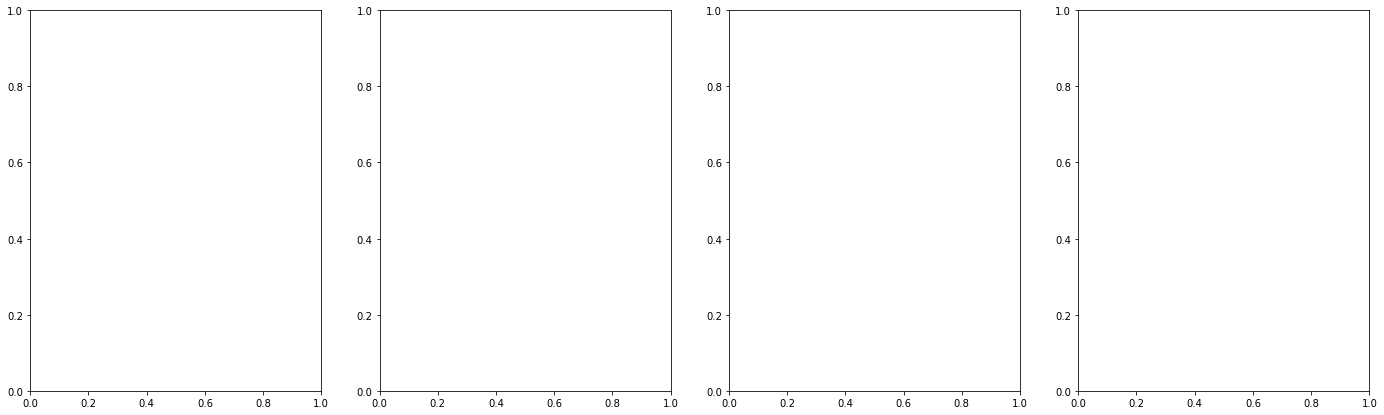

In [11]:
#Plotting residuals

fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (24,7))
ax1, ax2, ax3, ax4 = axs

ax1.contourf(xi,yi,gauss1(x1, y1)-interp_dish1,100,cmap='jet')
ax1.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax1.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax1.set_xlabel('radians')
ax1.set_ylabel('radians')
ax1.set_title('Flight 342, N dish, 1208 MHz Residual')
#ax1.imshow(np.log10(residual1), origin = 'bottom', aspect = 'auto', cmap = 'jet')

ax2.contourf(xi,yi,gauss2(x1, y1)-interp_dish2,100,cmap='jet')
ax2.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax2.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax2.set_xlabel('radians')
ax2.set_ylabel('radians')
ax2.set_title('Flight 342, E dish, 1208 MHz Residual')
#ax2.imshow(np.log10(residual2), origin = 'bottom', aspect = 'auto', cmap = 'jet')

ax3.contourf(xi,yi,gauss3(x1, y1)-interp_dish3,100,cmap='jet')
ax3.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax3.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax3.set_xlabel('radians')
ax3.set_ylabel('radians')
ax3.set_title('Flight 342, S dish, 1208 MHz Residual')
#ax3.imshow(np.log10(residual3), origin = 'bottom', aspect = 'auto', cmap = 'jet')

ax4.contourf(xi,yi,gauss4(x1, y1)-interp_dish4,100,cmap='jet')
ax4.plot([0,0],[-0.2,0.2], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax4.plot([-0.2,0.2],[0,0], color = 'black', markersize = 0, linestyle = 'solid', linewidth = 1.5)
ax4.set_xlabel('radians')
ax4.set_ylabel('radians')
ax4.set_title('Flight 342, W dish, 1208 MHz Residual')
#ax4.imshow(np.log10(residual4), origin = 'bottom', aspect = 'auto', cmap = 'jet')

#plt.savefig('Flight342_1208MHz_residual.png')